In [280]:
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine_vector, Unit
import osmnx as ox
import pickle
import os
from tqdm import tqdm
import folium
from rtree import index

In [173]:
stops_df = pd.read_csv(r"../Dataset/bus_stop.csv")

C:\Users\Adarsh\AppData\Local\Temp\ipykernel_39468\2268917618.py:1: DtypeWarning: Columns (6,16,17,18,19,21,22,23,25,26,27,28,29,32,35,36,40,53,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  stops_df = pd.read_csv(r"../Dataset/bus_stop.csv")


In [221]:
gps_df = pd.read_csv(r"../Dataset/GPS.csv",nrows=1000000)

In [222]:
print(len(gps_df))
gps_df.head()

1000000


,DEVICE_ID,IST_DATE,LAT,LONGITUDE
0,181221399,2000-10-13 06:30:00,0.000000,77.701782
1,181221399,2000-10-13 06:30:00,0.000000,77.701782
2,181221399,2000-10-13 06:30:00,0.000000,77.701782
3,9999572791,2019-10-13 00:15:18,13.029256,77.593023
4,9999572791,2019-10-13 00:15:33,13.029256,77.593023


In [223]:
# Drop duplicate based on DEVICE_ID, IST_DATE, LAT and LONGITUDE
gps_df = gps_df.drop_duplicates(subset=['DEVICE_ID','IST_DATE','LAT','LONGITUDE'])

In [224]:
# Filter the rows which LAT and LONGITUDE are between 12 and 14 and 77 and 79
stops_df = stops_df[(stops_df['latitude_current'] > 12) & (stops_df['latitude_current'] < 14) & (stops_df['longitude_current'] > 77) & (stops_df['longitude_current'] < 79)]
gps_df = gps_df[(gps_df['LAT'] > 12) & (gps_df['LAT'] < 14) & (gps_df['LONGITUDE'] > 77) & (gps_df['LONGITUDE'] < 79)]
print(len(gps_df))
gps_df.head()

949351


,DEVICE_ID,IST_DATE,LAT,LONGITUDE
3,9999572791,2019-10-13 00:15:18,13.029256,77.593023
4,9999572791,2019-10-13 00:15:33,13.029256,77.593023
5,9999572791,2019-10-13 00:15:46,13.029256,77.593023
6,9999572791,2019-10-13 00:16:03,13.029256,77.593023
7,9999572791,2019-10-13 00:16:18,13.029299,77.592891


In [225]:
# Plot the data point based on year, Day and date
gps_df['IST_DATE'] = pd.to_datetime(gps_df['IST_DATE'])
gps_df['YEAR'] = gps_df['IST_DATE'].dt.year
gps_df['DAY'] = gps_df['IST_DATE'].dt.dayofweek
gps_df['DATE'] = gps_df['IST_DATE'].dt.date
gps_df['TIME'] = gps_df['IST_DATE'].dt.time

In [226]:
gps_df['DATE'].value_counts()

DATE
2019-10-13    949351
Name: count, dtype: int64

In [227]:
# Remove the data points which are not in 2019
gps_df = gps_df[gps_df['YEAR'] == 2019]

In [228]:
# Filter with respect to DEVICE_ID which having more than 1000 data points
gps_df = gps_df.groupby('DEVICE_ID').filter(lambda x: len(x) > 100)

In [229]:
# Sort the dataframe by DEVICE_ID and then by IST_DATE
gps_df = gps_df.sort_values(by=['DEVICE_ID','IST_DATE'])
gps_df.head()

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME
2916,150211826,2019-10-13 00:00:03,13.043971,77.594109,2019,6,2019-10-13,00:00:03
4050,150211826,2019-10-13 00:00:13,13.043971,77.594109,2019,6,2019-10-13,00:00:13
5156,150211826,2019-10-13 00:00:23,13.043971,77.594109,2019,6,2019-10-13,00:00:23
6241,150211826,2019-10-13 00:00:33,13.043971,77.594109,2019,6,2019-10-13,00:00:33
7208,150211826,2019-10-13 00:00:43,13.043971,77.594109,2019,6,2019-10-13,00:00:43


In [230]:
# Shift the rows by 1 and get the previous row's LAT and LONGITUDE and IST_DATE
gps_df['PREV_LAT'] = gps_df.groupby(['DEVICE_ID'])['LAT'].shift(1)
gps_df['PREV_LONGITUDE'] = gps_df.groupby(['DEVICE_ID'])['LONGITUDE'].shift(1)
gps_df['PREV_IST_DATE'] = gps_df.groupby(['DEVICE_ID'])['IST_DATE'].shift(1)
gps_df.head()

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE
2916,150211826,2019-10-13 00:00:03,13.043971,77.594109,2019,6,2019-10-13,00:00:03,NaN,NaN,NaT
4050,150211826,2019-10-13 00:00:13,13.043971,77.594109,2019,6,2019-10-13,00:00:13,13.043971,77.594109,2019-10-13 00:00:03
5156,150211826,2019-10-13 00:00:23,13.043971,77.594109,2019,6,2019-10-13,00:00:23,13.043971,77.594109,2019-10-13 00:00:13
6241,150211826,2019-10-13 00:00:33,13.043971,77.594109,2019,6,2019-10-13,00:00:33,13.043971,77.594109,2019-10-13 00:00:23
7208,150211826,2019-10-13 00:00:43,13.043971,77.594109,2019,6,2019-10-13,00:00:43,13.043971,77.594109,2019-10-13 00:00:33


In [231]:
# Drop the na values
gps_df = gps_df.dropna()

In [232]:
# Calculate the distance between the current row and the previous row using haversine formula
gps_df['DISTANCE'] = haversine_vector(gps_df[['LAT','LONGITUDE']],gps_df[['PREV_LAT','PREV_LONGITUDE']],Unit.METERS)

In [233]:
# Calculate the time difference between the current row and the previous row
gps_df['TIME_DIFF'] = (pd.to_datetime(gps_df['IST_DATE']) - pd.to_datetime(gps_df['PREV_IST_DATE'])).dt.total_seconds()

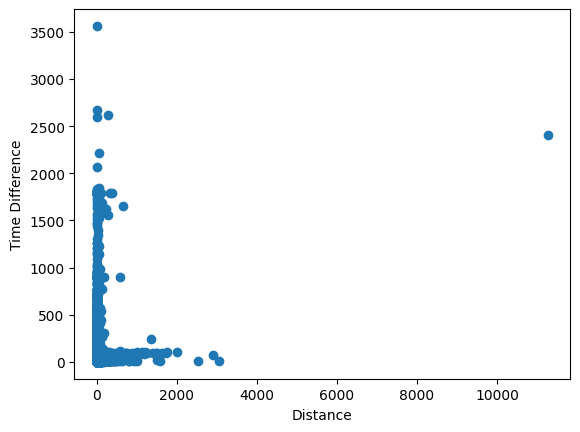

In [234]:
# PLot the distance and time difference
plt.scatter(gps_df['DISTANCE'],gps_df['TIME_DIFF'])
plt.xlabel('Distance')
plt.ylabel('Time Difference')
plt.show()

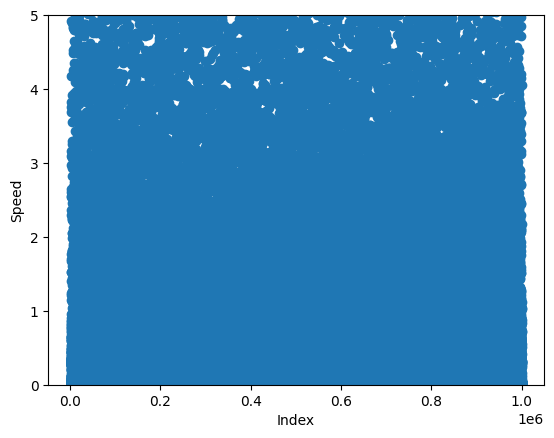

In [235]:
gps_df['SPEED'] = gps_df['DISTANCE'] / (gps_df['TIME_DIFF'] +0.0001) *18/5

# Plot the scatter plot speed with respect index
plt.scatter(gps_df.index,gps_df['SPEED'])
plt.ylim(0,5)
plt.xlabel('Index')
plt.ylabel('Speed')
plt.show()

In [236]:
# Value counts of speed between 0 and 1
gps_df[(gps_df['SPEED'] > 0) & (gps_df['SPEED'] < 1)]['SPEED'].value_counts()

SPEED
0.040030    31683
0.040030    21369
0.080060     4692
0.040030     4033
0.044478     2372
            ...  
0.606563        1
0.701421        1
0.350741        1
0.314616        1
0.145019        1
Name: count, Length: 51155, dtype: int64

In [238]:
gps_df['SPEED'].min()

0.0

In [239]:
# reset the index
gps_df = gps_df.reset_index(drop=True)

# Add column stop_time and initialize it with 0
gps_df['STOP_TIME'] = 0

# Take the dataframe with speed 0
gps_df0 = gps_df[gps_df['SPEED'] == 0]

# # Iterate over the dataframe with speed 0 and add the time_diff with the previous rows STOP_TIME to the current row STOP_TIME
prev_index = 0
for index,row in tqdm(gps_df0.iterrows(),total=len(gps_df0)):
    if index > 0 and row['DEVICE_ID'] == gps_df0.loc[prev_index,'DEVICE_ID']:
        gps_df.loc[index,'STOP_TIME'] = gps_df.loc[index-1,'STOP_TIME'] + row['TIME_DIFF']
    else:
        gps_df.loc[index,'STOP_TIME'] = row['TIME_DIFF']
    prev_index = index
    


100%|██████████| 663531/663531 [02:26<00:00, 4541.82it/s]


In [240]:
len(gps_df0)

663531

In [241]:
st = gps_df.loc[gps_df['STOP_TIME'] > 600,['LAT','LONGITUDE']].groupby(['LAT','LONGITUDE']).count()
st = st.reset_index()

In [242]:
# Filter the gps_df with respect to STOP_TIME less than 600 and LAT and LONGITUDE are not in st
gps_df = gps_df[gps_df['STOP_TIME'] < 600]

gps_df = gps_df[~((gps_df['LAT'].isin(st['LAT'])) & (gps_df['LONGITUDE'].isin(st['LONGITUDE'])))]

len(gps_df)


443869

In [243]:
# Plot the st and stops_df on folium plot in different colours and as circular markers
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in st.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='red',fill=True).add_to(m)
for index,row in stops_df.iterrows():
    folium.CircleMarker([row['latitude_current'],row['longitude_current']],radius=0.01,color='blue',fill=True).add_to(m)
m.save('stops.html')

In [244]:
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in st.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='red',fill=True).add_to(m)
for index,row in gps_df.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='blue',fill=True).add_to(m)
m.save('pings.html')

In [245]:
gps_df0.head(100)

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME
0,150211826,2019-10-13 00:00:13,13.043971,77.594109,2019,6,2019-10-13,00:00:13,13.043971,77.594109,2019-10-13 00:00:03,0.0,10.0,0.0,0
1,150211826,2019-10-13 00:00:23,13.043971,77.594109,2019,6,2019-10-13,00:00:23,13.043971,77.594109,2019-10-13 00:00:13,0.0,10.0,0.0,0
2,150211826,2019-10-13 00:00:33,13.043971,77.594109,2019,6,2019-10-13,00:00:33,13.043971,77.594109,2019-10-13 00:00:23,0.0,10.0,0.0,0
3,150211826,2019-10-13 00:00:43,13.043971,77.594109,2019,6,2019-10-13,00:00:43,13.043971,77.594109,2019-10-13 00:00:33,0.0,10.0,0.0,0
4,150211826,2019-10-13 00:00:53,13.043971,77.594109,2019,6,2019-10-13,00:00:53,13.043971,77.594109,2019-10-13 00:00:43,0.0,10.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,150211826,2019-10-13 00:20:32,13.043591,77.594078,2019,6,2019-10-13,00:20:32,13.043591,77.594078,2019-10-13 00:20:22,0.0,10.0,0.0,0
117,150211826,2019-10-13 00:20:42,13.043591,77.594078,2019,6,2019-10-13,00:20:42,13.043591,77.594078,2019-10-13 00:20:32,0.0,10.0,0.0,0
118,150211826,2019-10-13 00:20:52,13.043591,77.594078,2019,6,2019-10-13,00:20:52,13.043591,77.594078,2019-10-13 00:20:42,0.0,10.0,0.0,0
119,150211826,2019-10-13 00:21:02,13.043591,77.594078,2019,6,2019-10-13,00:21:02,13.043591,77.594078,2019-10-13 00:20:52,0.0,10.0,0.0,0


In [246]:
# Filter the gps data with respect to speed less than 60
gps_df = gps_df[gps_df['SPEED'] < 60]
print(gps_df.SPEED.mean())

2.3560103340673018


In [247]:
# Value counts of speed
print(len(gps_df))
gps_df['SPEED'].value_counts()

439978


SPEED
0.000000     249151
0.040030      31265
0.040030      21102
0.080060       4634
0.040030       3976
              ...  
21.984164         1
15.277730         1
5.003729          1
0.911346          1
0.334814          1
Name: count, Length: 101447, dtype: int64

In [248]:
# Get the number of unique gps based on LAT and LONGITUDE
gps_df.groupby(['LAT','LONGITUDE']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count',ascending=False)

,LAT,LONGITUDE,count
17152,12.871454,77.721924,115
75911,12.972237,77.441559,109
18180,12.872490,77.585907,103
5378,12.780834,77.634506,97
2769,12.779082,77.770554,94
...,...,...,...
62469,12.955254,77.595383,1
62468,12.955254,77.595337,1
62467,12.955254,77.595329,1
62466,12.955254,77.595314,1


In [249]:
# Find stop-stop segments from stop_times.txt
stop_times_df = pd.read_csv(r"../Dataset/route_point.csv")
stop_times_df.head()

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date
0,11459,1078,6461,16396,1,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27
1,11460,1078,7193,16396,2,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27
2,11461,1078,6422,20415,3,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14
3,11462,1078,6692,20417,4,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14
4,11463,1078,8537,20420,5,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14


In [250]:
# Get the stops cooresponding to the route_id == 1078
stops = stop_times_df.loc[stop_times_df['route_id'] == 1078,'bus_stop_id']
# Merge the stops_df with stops on bus_stop_id 
stops = pd.merge(stops,stops_df[['bus_stop_id','latitude_current','longitude_current']],on='bus_stop_id')

In [251]:
def check_ping(point1,point2,ping):
    if ping[0] >= min(point1[0],point2[0]) and ping[0] <= max(point1[0],point2[0]) and ping[1] >= min(point1[1],point2[1]) and ping[1] <= max(point1[1],point2[1]):
        return True
    else:
        return False

In [277]:
# Filter the gps_df with respect to DISTANCE more than 10
gps_df.loc[gps_df['DISTANCE'] > 100,:].head(100)

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME
9581,150218092,2019-10-13 01:05:38,13.100422,77.594093,2019,6,2019-10-13,01:05:38,13.101275,77.595047,2019-10-13 01:05:28,140.254232,10.0,50.491019,0
9594,150218092,2019-10-13 01:07:48,13.101042,77.594955,2019,6,2019-10-13,01:07:48,13.100422,77.594093,2019-10-13 01:07:38,116.052139,10.0,41.778352,0
9696,150218092,2019-10-13 01:24:44,13.100133,77.595184,2019,6,2019-10-13,01:24:44,13.101094,77.594727,2019-10-13 01:24:34,117.763951,10.0,42.394599,0
9732,150218092,2019-10-13 01:30:43,13.101383,77.594994,2019,6,2019-10-13,01:30:43,13.100133,77.595184,2019-10-13 01:30:33,140.508758,10.0,50.582647,0
15324,150218137,2019-10-13 00:00:16,12.916446,77.639992,2019,6,2019-10-13,00:00:16,12.917324,77.640999,2019-10-13 00:00:06,146.434339,10.0,52.715835,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16631,150218177,2019-10-13 00:44:50,12.906312,77.581657,2019,6,2019-10-13,00:44:50,12.906270,77.582680,2019-10-13 00:44:40,110.977109,10.0,39.951360,0
16632,150218177,2019-10-13 00:45:00,12.906330,77.580658,2019,6,2019-10-13,00:45:00,12.906312,77.581657,2019-10-13 00:44:50,108.296021,10.0,38.986178,0
16640,150218177,2019-10-13 00:46:20,12.906402,77.577103,2019,6,2019-10-13,00:46:20,12.906358,77.578133,2019-10-13 00:46:09,111.744620,11.0,36.570634,0
16644,150218177,2019-10-13 00:47:00,12.906400,77.574081,2019,6,2019-10-13,00:47:00,12.906410,77.575050,2019-10-13 00:46:50,105.031798,10.0,37.811069,0


In [279]:
gps_df_bus1 = gps_df.loc[gps_df['DEVICE_ID'] == 150218177,:]
gps_df_bus1.head(100)

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME
16362,150218177,2019-10-13 00:01:01,13.164146,77.629158,2019,6,2019-10-13,00:01:01,13.164267,77.629250,2019-10-13 00:00:59,16.740677,2.0,30.131712,0
16409,150218177,2019-10-13 00:08:39,13.084632,77.594170,2019,6,2019-10-13,00:08:39,13.085685,77.594604,2019-10-13 00:08:29,126.171413,10.0,45.421255,0
16410,150218177,2019-10-13 00:08:49,13.083401,77.593681,2019,6,2019-10-13,00:08:49,13.084632,77.594170,2019-10-13 00:08:39,146.770244,10.0,52.836760,0
16411,150218177,2019-10-13 00:08:59,13.081986,77.593262,2019,6,2019-10-13,00:08:59,13.083401,77.593681,2019-10-13 00:08:49,163.754933,10.0,58.951186,0
16429,150218177,2019-10-13 00:11:38,13.051045,77.593193,2019,6,2019-10-13,00:11:38,13.051375,77.593277,2019-10-13 00:11:35,37.805702,3.0,45.365330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16532,150218177,2019-10-13 00:28:24,12.956367,77.592331,2019,6,2019-10-13,00:28:24,12.957315,77.592690,2019-10-13 00:28:14,112.362380,10.0,40.450052,0
16533,150218177,2019-10-13 00:28:34,12.955678,77.592148,2019,6,2019-10-13,00:28:34,12.956367,77.592331,2019-10-13 00:28:24,79.138298,10.0,28.489502,0
16534,150218177,2019-10-13 00:28:44,12.955214,77.592552,2019,6,2019-10-13,00:28:44,12.955678,77.592148,2019-10-13 00:28:34,67.665503,10.0,24.359338,0
16535,150218177,2019-10-13 00:28:54,12.954757,77.592628,2019,6,2019-10-13,00:28:54,12.955214,77.592552,2019-10-13 00:28:44,51.479204,10.0,18.532328,0


In [254]:
mergerd_busstops_routepoints = pd.merge(stop_times_df,stops_df[['bus_stop_id','latitude_current','longitude_current']],on='bus_stop_id')
mergerd_busstops_routepoints.head(100)

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,latitude_current,longitude_current
0,11459,1078,6461,16396,1,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.80207
1,146620,4897,6461,16396,1,ACTIVE,Y,N,2014-11-03 09:41:02,41,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.80207
2,216716,6961,6461,16396,75,ACTIVE,Y,N,2015-01-16 16:32:01,9,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.80207
3,216758,6963,6461,16396,1,ACTIVE,Y,N,2015-01-16 16:43:34,9,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.80207
4,679180,23026,6461,16396,32,ACTIVE,Y,N,2015-11-13 12:01:39,135,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.80207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,682802,23118,6380,20511,17,ACTIVE,Y,N,2015-11-13 14:33:54,135,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.80309
96,682846,23121,6380,20511,21,ACTIVE,N,N,2015-11-13 14:38:03,135,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.80309
97,731618,24529,6380,20511,20,ACTIVE,Y,N,2015-11-19 16:08:01,7,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.80309
98,749808,25127,6380,20511,21,ACTIVE,N,N,2015-11-24 11:29:35,99,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.80309


In [255]:
# sortby route_id and then by route_order
mergerd_busstops_routepoints = mergerd_busstops_routepoints.sort_values(by=['route_id','route_order'])
mergerd_busstops_routepoints.head(100)

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,latitude_current,longitude_current
0,11459,1078,6461,16396,1,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.802070
11,11460,1078,7193,16396,2,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.291506,77.806074
19,11461,1078,6422,20415,3,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.279805,77.820746
25,11462,1078,6692,20417,4,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.271906,77.844764
31,11463,1078,8537,20420,5,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.270515,77.848786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20837,16830,1206,345,23832,14,ACTIVE,Y,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.943920,77.576796
20991,16831,1206,2731,23404,15,ACTIVE,Y,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.953088,77.576745
21124,16832,1206,2730,23877,16,ACTIVE,N,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.955899,77.577194
21306,16833,1206,3017,19610,17,ACTIVE,N,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.958042,77.573800


In [256]:
print(len(mergerd_busstops_routepoints))
print(mergerd_busstops_routepoints.route_id.nunique())

632273
24233


In [257]:
# Rename latitude_current and longitude_current to origin_lat and origin_long
mergerd_busstops_routepoints = mergerd_busstops_routepoints.rename(columns={'latitude_current':'origin_lat','longitude_current':'origin_long'})

# Create a new column destination_lat and destination_long and assign with the next row's origin_lat and origin_long
mergerd_busstops_routepoints['destination_lat'] = mergerd_busstops_routepoints['origin_lat'].shift(-1)
mergerd_busstops_routepoints['destination_long'] = mergerd_busstops_routepoints['origin_long'].shift(-1)

# Drop the last row for every route_id 
mergerd_busstops_routepoints = mergerd_busstops_routepoints.groupby('route_id').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

# print the length of the dataframe
print(len(mergerd_busstops_routepoints))

608040


In [269]:
# Drop the duplicates based on origin_lat, origin_long, destination_lat and destination_long
mergerd_busstops_routepoints = mergerd_busstops_routepoints.drop_duplicates(subset=['origin_lat','origin_long','destination_lat','destination_long'])
# reset the index
mergerd_busstops_routepoints = mergerd_busstops_routepoints.reset_index(drop=True)
print(len(mergerd_busstops_routepoints))

40668


In [259]:
mergerd_busstops_routepoints.head(100)

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,origin_lat,origin_long,destination_lat,destination_long
0,11459,1078,6461,16396,1,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.294807,77.802070,13.291506,77.806074
1,11460,1078,7193,16396,2,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.291506,77.806074,13.279805,77.820746
2,11461,1078,6422,20415,3,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.279805,77.820746,13.271906,77.844764
3,11462,1078,6692,20417,4,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.271906,77.844764,13.270515,77.848786
4,11463,1078,8537,20420,5,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.270515,77.848786,13.261363,77.846914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16833,1206,3017,19610,17,ACTIVE,N,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.958042,77.573800,12.961733,77.577006
96,16834,1206,8523,0,18,ACTIVE,N,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.961733,77.577006,12.961598,77.577355
97,16835,1206,8522,0,19,ACTIVE,N,N,2014-08-25 17:14:32,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.961598,77.577355,12.960165,77.577171
98,17529,1226,3014,19586,1,ACTIVE,Y,N,2014-08-27 13:31:18,6,NaN,NaN,0,NaN,2018-02-19 12:10:14,12.960165,77.577171,12.959172,77.576735


In [281]:
# Create an R-tree index
idx = index.Index()
 
# Populate the R-tree index with stop segments
for i, row in mergerd_busstops_routepoints.iterrows():
    start_lat, start_lon, end_lat, end_lon = row['origin_lat'], row['origin_long'], row['destination_lat'], row['destination_long']
    idx.insert(i, (min(start_lat, end_lat), min(start_lon, end_lon), max(start_lat, end_lat), max(start_lon, end_lon)))

In [282]:
# Function to find the stop segment for a given GPS ping
def find_stop_segment(gps_lat, gps_lon):
    for segment_id in idx.intersection((gps_lat, gps_lon, gps_lat, gps_lon)):
        start_lat, start_lon, end_lat, end_lon = mergerd_busstops_routepoints.loc[segment_id, ['origin_lat', 'origin_long', 'destination_lat', 'destination_long']]
        if min(start_lat, end_lat) <= gps_lat <= max(start_lat, end_lat) and min(start_lon, end_lon) <= gps_lon <= max(start_lon, end_lon):
            return segment_id
    return None  # GPS ping does not belong to any stop segment

In [283]:
# create a new column segment id and find it using find_stop_segment function
gps_df_bus1['segment_id'] = gps_df_bus1.apply(lambda x: find_stop_segment(x['LAT'],x['LONGITUDE']),axis=1)
gps_df_bus1.head(100)

C:\Users\Adarsh\AppData\Local\Temp\ipykernel_39468\1827242174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_df_bus1['segment_id'] = gps_df_bus1.apply(lambda x: find_stop_segment(x['LAT'],x['LONGITUDE']),axis=1)


,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME,segment_id
16362,150218177,2019-10-13 00:01:01,13.164146,77.629158,2019,6,2019-10-13,00:01:01,13.164267,77.629250,2019-10-13 00:00:59,16.740677,2.0,30.131712,0,8168
16409,150218177,2019-10-13 00:08:39,13.084632,77.594170,2019,6,2019-10-13,00:08:39,13.085685,77.594604,2019-10-13 00:08:29,126.171413,10.0,45.421255,0,32207
16410,150218177,2019-10-13 00:08:49,13.083401,77.593681,2019,6,2019-10-13,00:08:49,13.084632,77.594170,2019-10-13 00:08:39,146.770244,10.0,52.836760,0,32207
16411,150218177,2019-10-13 00:08:59,13.081986,77.593262,2019,6,2019-10-13,00:08:59,13.083401,77.593681,2019-10-13 00:08:49,163.754933,10.0,58.951186,0,32207
16429,150218177,2019-10-13 00:11:38,13.051045,77.593193,2019,6,2019-10-13,00:11:38,13.051375,77.593277,2019-10-13 00:11:35,37.805702,3.0,45.365330,0,34130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16532,150218177,2019-10-13 00:28:24,12.956367,77.592331,2019,6,2019-10-13,00:28:24,12.957315,77.592690,2019-10-13 00:28:14,112.362380,10.0,40.450052,0,11241
16533,150218177,2019-10-13 00:28:34,12.955678,77.592148,2019,6,2019-10-13,00:28:34,12.956367,77.592331,2019-10-13 00:28:24,79.138298,10.0,28.489502,0,11241
16534,150218177,2019-10-13 00:28:44,12.955214,77.592552,2019,6,2019-10-13,00:28:44,12.955678,77.592148,2019-10-13 00:28:34,67.665503,10.0,24.359338,0,11241
16535,150218177,2019-10-13 00:28:54,12.954757,77.592628,2019,6,2019-10-13,00:28:54,12.955214,77.592552,2019-10-13 00:28:44,51.479204,10.0,18.532328,0,11241


In [284]:
gps_df_bus1.segment_id.value_counts()

segment_id
35308    91
35288    48
11241    45
486      38
11707    26
31170    11
11780    10
19270    10
33188     8
23152     7
24118     6
35254     4
34130     4
35162     3
32207     3
2480      2
12116     2
7950      2
36169     2
28463     2
28462     2
35255     1
22510     1
25985     1
21481     1
8168      1
Name: count, dtype: int64

In [285]:
# Plot the gps pings present in gps_df_bus1 as circular marker and origin lat and origin long as red marker from merged_busstops_routepoints as marker
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for idex,row in mergerd_busstops_routepoints.iterrows():
    if idex in gps_df_bus1['segment_id'].unique():
        folium.Marker([row['origin_lat'],row['origin_long']],popup=row['route_id'],icon=folium.Icon(color='red')).add_to(m)
    # folium.Marker([row['origin_lat'],row['origin_long']],popup=row['route_id'],icon=folium.Icon(color='red')).add_to(m)
for index,row in gps_df_bus1.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='blue',fill=True).add_to(m)

m.save('bus1.html')
    

In [133]:
# Plot the stop_lat_long using Folium
import folium
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in stops.loc[:,:].iterrows():
    folium.Marker([row['latitude_current'],row['longitude_current']],popup=row['bus_stop_id']).add_to(m)

# Save the map as html file
m.save('stops_full.html')

In [131]:
# Plot the gps pings of DEVICE_ID == 150211826
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in gps_df.loc[gps_df['DEVICE_ID'] == 150218012,:].iterrows():
    folium.Marker([row['LAT'],row['LONGITUDE']],popup=row['DEVICE_ID']).add_to(m)

m.save('gps.html')

In [132]:
gps_df.loc[gps_df['DEVICE_ID'] == 150211826,:].count()

DEVICE_ID         6602
IST_DATE          6602
LAT               6602
LONGITUDE         6602
YEAR              6602
DAY               6602
DATE              6602
TIME              6602
PREV_LAT          6602
PREV_LONGITUDE    6602
PREV_IST_DATE     6602
DISTANCE          6602
TIME_DIFF         6602
SPEED             6602
dtype: int64

In [112]:
gps_df.DEVICE_ID.unique()

array([150211826, 150218002, 150218006, ..., 181222810, 181222856,
       181222935], dtype=int64)